# 🤖 Automated Reason Markup Pipeline

This notebook automatically fills missing `reason` values in the dataset using OpenRouter's LLM API with **async processing** for 2x faster performance and **live logging** to monitor predictions in real-time.

## ⚡ Quick Start

1. **Set your API key** (choose one method):
   ```bash
   # In terminal:
   export OPENROUTER_API_KEY="sk-or-v1-..."
   ```
   Or edit the key directly in the configuration cell below.

2. **Run all cells** from top to bottom

3. **Watch live logs** as predictions are made:
   - See last 5 predictions in real-time
   - Monitor input text, expected vs. actual outputs
   - Track correct/incorrect predictions with 🟢/🔴 indicators

4. **Wait for results**:
   - Pipeline tests accuracy first (async with 2 workers)
   - Only proceeds if accuracy ≥ 80%
   - Creates `mobile_marked_up.csv` if successful

## 📊 Pipeline Overview

```
1. Load Data & Simplify Categories (33 → 15 categories)
2. Setup OpenRouter API with async processing
3. Test Accuracy on Sample (50-100 samples, 2 concurrent workers)
   → Live logs show last 5 predictions
4. ✓ If accuracy ≥ 80% → Fill all 818 missing values (async)
   ✗ If accuracy < 80% → Stop and suggest improvements
5. Visualize Results
6. Save Updated Dataset
```

## ⚡ Performance Features
- **Async processing**: 2 concurrent API calls (~2x faster)
- **Live logging**: Monitor last 5 predictions in real-time
- **Smart category grouping**: 33 → 15 categories (better accuracy)
- **Estimated time**: ~30-45 minutes (vs ~1-2 hours sequential)

---

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

colors = {
    'bg': '#EFE8E8',
    'text': '#513838',
    
    'red': '#DC3545',
    'blue': "#4476C2",
    'cyan': '#0AA2C0',
    'green': '#1AA179',
    'purple': '#7121F3',
    'orange': '#FD7E14',
    'yellow': '#FFC107',
    'pink': '#D63384',
    'white_green': "#64B099"
}

custom_palette = [
    colors['blue'], colors['red'], colors['green'], 
    colors['orange'], colors['purple'], colors['cyan']
]

custom_params = {
    "figure.facecolor": colors['bg'],
    "axes.facecolor": colors['bg'],
    "savefig.facecolor": colors['bg'],
    
    "text.color": colors['text'],
    "axes.labelcolor": colors['text'],
    "xtick.color": colors['text'],
    "ytick.color": colors['text'],
    "font.family": "sans-serif",
    
    "axes.grid": True,
    "grid.color": colors['text'],
    "grid.alpha": 0.15,
    "grid.linestyle": "-",
    "grid.linewidth": 0.8,
    
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.edgecolor": colors['text'],
    "axes.linewidth": 0.8,
    
    "lines.linewidth": 1.5,
    "lines.markersize": 6,
}

sns.set_theme(
    context="talk",
    style="whitegrid",
    rc=custom_params,
    palette=custom_palette
)

# Helper to avoid overlapping x tick labels: wraps long labels, rotates, and
# ensures enough bottom margin. Use `fix_tick_labels(ax)` after drawing plots.
def fix_tick_labels(ax=None, rotation=45, ha='right', wrap_width=20, bottom=0.30):
    import textwrap
    if ax is None:
        ax = plt.gca()
    labels = [t.get_text() for t in ax.get_xticklabels()]
    if any(labels):
        wrapped = [textwrap.fill(l, wrap_width) if l else l for l in labels]
        ax.set_xticklabels(wrapped, rotation=rotation, ha=ha)
    # Increase bottom margin to make room for multi-line labels
    try:
        fig = ax.get_figure()
        fig.subplots_adjust(bottom=bottom)
    except Exception:
        plt.subplots_adjust(bottom=bottom)
    plt.tight_layout()


<Figure size 1400x800 with 0 Axes>

In [2]:
df = pd.read_csv("mobile.csv")
df

,review_dttm,finish_dttm,id_client,company,review_mark,review_emotion,review_source,business_line,product,reason,...,citizenship_country,segment_name,subscription_important_flg,new_flg,influencer_flg,age_segment,no_mark_flag,review_mark_numeric,is_credit_product,is_mobile_product
0,2025-07-05 12:29:00,2025-07-26 12:23:15.142,aa5b83b388c7c5fb210c0bb4c585b184,Мобайл,2,0,пикабу,mobile,Мобильная связь,Не определено,...,РФ,NaN,NaN,NaN,NaN,Взрослые,True,2,False,True
1,2025-02-01 13:38:00,2025-02-01 16:56:47.945,54a44046083c8f4809d123b52afdda7f,Мобайл,1,0,суперапп,Не определено,Не определено,Не определено,...,РФ,Малодоходные,0.0,0.0,0.0,Не определен,False,1,False,True
2,2025-04-28 22:12:16,2025-04-30 19:34:47.434,57059ea5dedfe7419b519c2d4ad117d4,Мобайл,1,0,banki.ru,mobile,Мобильная связь,актуализация,...,БЕЛАРУСЬ,Доходные,0.0,0.0,0.0,Взрослые,False,1,False,True
3,2025-09-28 19:18:01,2025-10-09 10:58:16.458,d19d29384f1a243c90f3d2d7c406e0a5,Мобайл,2,0,banki.ru,mobile,Мобильная связь,качество связи,...,РФ,Доходные,0.0,0.0,0.0,Сеньоры,True,2,False,True
4,2025-10-11 18:44:00,2025-10-12 12:29:14.498,85d1124bd21fc016ab5645d4b41b69fe,Мобайл,2,0,otzovik,mobile,Мобильная связь,претензия на работу доп услуг,...,РФ,Доходные,0.0,0.0,1.0,Взрослые,True,2,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242,2025-03-01 15:35:00.000,2025-03-04 16:47:20.875,73d39fced22add37636b5af60e215316,Мобайл,1,0,otzovik,mobile,Мобильная связь,заблокировать сим-карту/разблокировать сим-карту,...,РФ,Защищенные,0.0,1.0,0.0,Взрослые,False,1,False,True
1243,2025-04-15 19:00:00.000,2025-04-16 00:21:41.877,c0cc163c793b6c3d6af0f4867986b6d4,Мобайл,1,0,иная площадка,Не определено,Не определено,Не определено,...,РФ,Малодоходные,0.0,0.0,0.0,Сеньоры,False,1,False,True
1244,2025-03-21 16:13:53.000,2025-03-24 15:35:11.007,719ae1c7168ecd8ee72664241d6eb289,Мобайл,1,0,banki.ru,mobile,Мобильная связь,заявки,...,РФ,Доходные,0.0,0.0,0.0,Сеньоры,False,1,False,True
1245,2025-01-15 18:24:00.000,2025-01-21 11:09:38.851,23bcc6fec4e7a0d5ef925ea751433680,Мобайл,1,0,otzovik,Не определено,Не определено,Не определено,...,РФ,Доходные,0.0,0.0,0.0,Сеньоры,False,1,False,True


In [3]:
# Examine dataset structure
print(df.columns)
print(f"\nDataset shape: {df.shape}")
print(f"\nReason column value counts:")
print(df['reason'].value_counts())
print(f"\nMissing values (Не определено): {(df['reason'] == 'Не определено').sum()}")
print(f"\nSample reviews:")
print(df[['review_text', 'reason']].head(10))

Index(['review_dttm', 'finish_dttm', 'id_client', 'company', 'review_mark',
       'review_emotion', 'review_source', 'business_line', 'product', 'reason',
       'review_theme', 'subtheme', 'review_text', 'solution_flg', 'gender_cd',
       'education_level_cd', 'marital_status_cd', 'children_cnt',
       'citizenship_country', 'segment_name', 'subscription_important_flg',
       'new_flg', 'influencer_flg', 'age_segment', 'no_mark_flag',
       'review_mark_numeric', 'is_credit_product', 'is_mobile_product'],
      dtype='object')

Dataset shape: (1247, 28)

Reason column value counts:
reason
Не определено                                       818
качество связи                                       70
тарификация мобайл                                   55
акции                                                51
заявки                                               33
актуализация                                         23
заблокировать сим-карту/разблокировать сим-карту     23
равнод

# Automated Markup Pipeline for Missing Reason Values

This notebook implements a complete pipeline to:
1. Extract existing categories from the `reason` column
2. Test model accuracy on known values
3. If accuracy ≥ 80%, fill missing values ("Не определено")
4. Save the updated dataset

## Step 1: Setup and Configuration

In [4]:
import os
import requests
import json
from sklearn.metrics import accuracy_score, classification_report
from tqdm.auto import tqdm
import time
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading

# Set your OpenRouter API key
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY", "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")

# Model configuration
MODEL_NAME = "google/gemini-3-pro-preview"  # Fast and free model
API_URL = "https://openrouter.ai/api/v1/chat/completions"

# Set accuracy threshold
ACCURACY_THRESHOLD = 0.80

# Async configuration
MAX_WORKERS = 2  # Number of concurrent threads

print(f"✓ Configuration loaded")
print(f"  Model: {MODEL_NAME}")
print(f"  Accuracy threshold: {ACCURACY_THRESHOLD * 100}%")
print(f"  Max concurrent workers: {MAX_WORKERS}")

✓ Configuration loaded
  Model: google/gemini-3-pro-preview
  Accuracy threshold: 80.0%
  Max concurrent workers: 2


## Step 2: Extract Categories and Prepare Data

In [5]:
# Extract valid categories (excluding "Не определено")
valid_categories = df[df['reason'] != 'Не определено']['reason'].unique().tolist()
valid_categories_sorted = sorted(valid_categories)

print(f"Found {len(valid_categories_sorted)} valid categories:")
for i, cat in enumerate(valid_categories_sorted, 1):
    count = (df['reason'] == cat).sum()
    print(f"  {i}. {cat} ({count} samples)")

# Prepare datasets
df_labeled = df[df['reason'] != 'Не определено'].copy()
df_unlabeled = df[df['reason'] == 'Не определено'].copy()

print(f"\n✓ Data split:")
print(f"  Labeled samples: {len(df_labeled)}")
print(f"  Unlabeled samples: {len(df_unlabeled)}")

Found 33 valid categories:
  1. актуализация (23 samples)
  2. акции (51 samples)
  3. восстановление договора (10 samples)
  4. встречи (16 samples)
  5. дедупликация (2 samples)
  6. заблокировать сим-карту/разблокировать сим-карту (23 samples)
  7. замена сим-карты (9 samples)
  8. заявки (33 samples)
  9. изменение данных (3 samples)
  10. качество связи (70 samples)
  11. манера общения (5 samples)
  12. маркетинговые коммуникации (2 samples)
  13. мне звонили (1 samples)
  14. нотификации (1 samples)
  15. общая информация (5 samples)
  16. общая информация доп услуги (6 samples)
  17. переводы внутрибанковские (1 samples)
  18. переводы межбанковские (1 samples)
  19. перенос номера (22 samples)
  20. переоформление sim-карты мобайл (3 samples)
  21. платежи внешние (13 samples)
  22. повторное обращение (2 samples)
  23. подключение/отключение доп услуг (13 samples)
  24. пополнение (1 samples)
  25. претензия на работу доп услуг (6 samples)
  26. приложение и сайт тинькофф (1 

## Step 2.5: Group Similar Categories

In [6]:
# RELOAD original data to ensure clean mapping
df = pd.read_csv("mobile.csv")

# Group similar categories to reduce confusion for the model
# Format: 'original_category': 'grouped_category'

category_mapping = {
    # --- 1. Качество связи (Connection Quality) ---
    'качество связи': 'Качество связи',

    # --- 2. Тарифы и Финансы (Tariffs & Billing) ---
    'тарификация мобайл': 'Тарифы и условия',
    'акции': 'Тарифы и условия',
    'скидки и корректировки': 'Тарифы и условия',

    # --- 3. Операции с SIM (SIM Operations) ---
    'заблокировать сим-карту/разблокировать сим-карту': 'Операции с SIM',
    'замена сим-карты': 'Операции с SIM',
    'переоформление sim-карты мобайл': 'Операции с SIM',
    'управление esim': 'Операции с SIM',

    # --- 4. Доп. услуги (VAS) ---
    'подключение/отключение доп услуг': 'Дополнительные услуги',
    'общая информация доп услуги': 'Дополнительные услуги',
    'претензия на работу доп услуг': 'Дополнительные услуги',

    # --- 5. Платежи (Payments) ---
    'платежи внешние': 'Платежи и переводы',
    'переводы внутрибанковские': 'Платежи и переводы',
    'переводы межбанковские': 'Платежи и переводы',
    'пополнение': 'Платежи и переводы',

    # --- 6. Договор и Заявки (Contract & Admin) ---
    'заявки': 'Договор и обслуживание',
    'восстановление договора': 'Договор и обслуживание',
    'расторжение договора': 'Договор и обслуживание',
    'актуализация': 'Договор и обслуживание',
    'изменение данных': 'Договор и обслуживание',

    # --- 7. MNP (Number Porting) ---
    'перенос номера': 'Перенос номера (MNP)',

    # --- 8. Поддержка (Support Quality) ---
    'равнодушие': 'Качество поддержки',
    'манера общения': 'Качество поддержки',

    # --- 9. Цифровые каналы (Digital Channels) ---
    'приложение и сайт тинькофф': 'Приложение и сайт',
    'сервисы в приложении': 'Приложение и сайт',
    'нотификации': 'Приложение и сайт',

    # --- 10. Системное/Прочее (Other) ---
    'дедупликация': 'Прочее/Системное',
    'повторное обращение': 'Прочее/Системное',
    'мне звонили': 'Прочее/Системное',
    'фрод-мониторинг мобайл': 'Прочее/Системное',
    'маркетинговые коммуникации': 'Прочее/Системное',
}

# Apply mapping to create simplified categories
df_original = df.copy()  # Keep original for reference
df_mapped = df.copy()

# Map categories
df_mapped['reason'] = df_mapped['reason'].replace(category_mapping)

# Get new simplified category list
simplified_categories = df_mapped[df_mapped['reason'] != 'Не определено']['reason'].unique().tolist()
simplified_categories_sorted = sorted(simplified_categories)

print("="*70)
print("CATEGORY SIMPLIFICATION")
print("="*70)
print(f"\nOriginal categories: {len(valid_categories_sorted)}")
print(f"Simplified categories: {len(simplified_categories_sorted)}")
print(f"Reduction: {len(valid_categories_sorted) - len(simplified_categories_sorted)} categories")

print(f"\n📊 New Simplified Categories ({len(simplified_categories_sorted)}):")
for i, cat in enumerate(simplified_categories_sorted, 1):
    count = (df_mapped['reason'] == cat).sum()
    print(f"  {i}. {cat} ({count} samples)")

print(f"\n🔄 Grouping Summary:")
# Show what was grouped
grouped_mappings = {}
for old_cat, new_cat in category_mapping.items():
    if new_cat not in grouped_mappings:
        grouped_mappings[new_cat] = []
    grouped_mappings[new_cat].append(old_cat)

for new_cat, old_cats in sorted(grouped_mappings.items()):
    print(f"\n  '{new_cat}' includes:")
    for old_cat in old_cats:
        old_count = (df_original['reason'] == old_cat).sum()
        print(f"    - {old_cat} ({old_count} samples)")
    new_count = (df_mapped['reason'] == new_cat).sum()
    print(f"    → Total: {new_count} samples")

# Update df to use mapped version
df = df_mapped.copy()

# Update labeled/unlabeled splits with mapped categories
df_labeled_mapped = df[df['reason'] != 'Не определено'].copy()
df_unlabeled_mapped = df[df['reason'] == 'Не определено'].copy()

print(f"\n✓ Categories simplified and data updated")
print("="*70)

CATEGORY SIMPLIFICATION

Original categories: 33
Simplified categories: 12
Reduction: 21 categories

📊 New Simplified Categories (12):
  1. Договор и обслуживание (82 samples)
  2. Дополнительные услуги (25 samples)
  3. Качество поддержки (28 samples)
  4. Качество связи (70 samples)
  5. Операции с SIM (39 samples)
  6. Перенос номера (MNP) (22 samples)
  7. Платежи и переводы (16 samples)
  8. Приложение и сайт (3 samples)
  9. Прочее/Системное (8 samples)
  10. Тарифы и условия (115 samples)
  11. встречи (16 samples)
  12. общая информация (5 samples)

🔄 Grouping Summary:

  'Договор и обслуживание' includes:
    - заявки (33 samples)
    - восстановление договора (10 samples)
    - расторжение договора (13 samples)
    - актуализация (23 samples)
    - изменение данных (3 samples)
    → Total: 82 samples

  'Дополнительные услуги' includes:
    - подключение/отключение доп услуг (13 samples)
    - общая информация доп услуги (6 samples)
    - претензия на работу доп услуг (6 samp

**Note:** The pipeline will use these simplified categories for prediction. The final output will contain the simplified category names, which are clearer and easier for the model to distinguish.

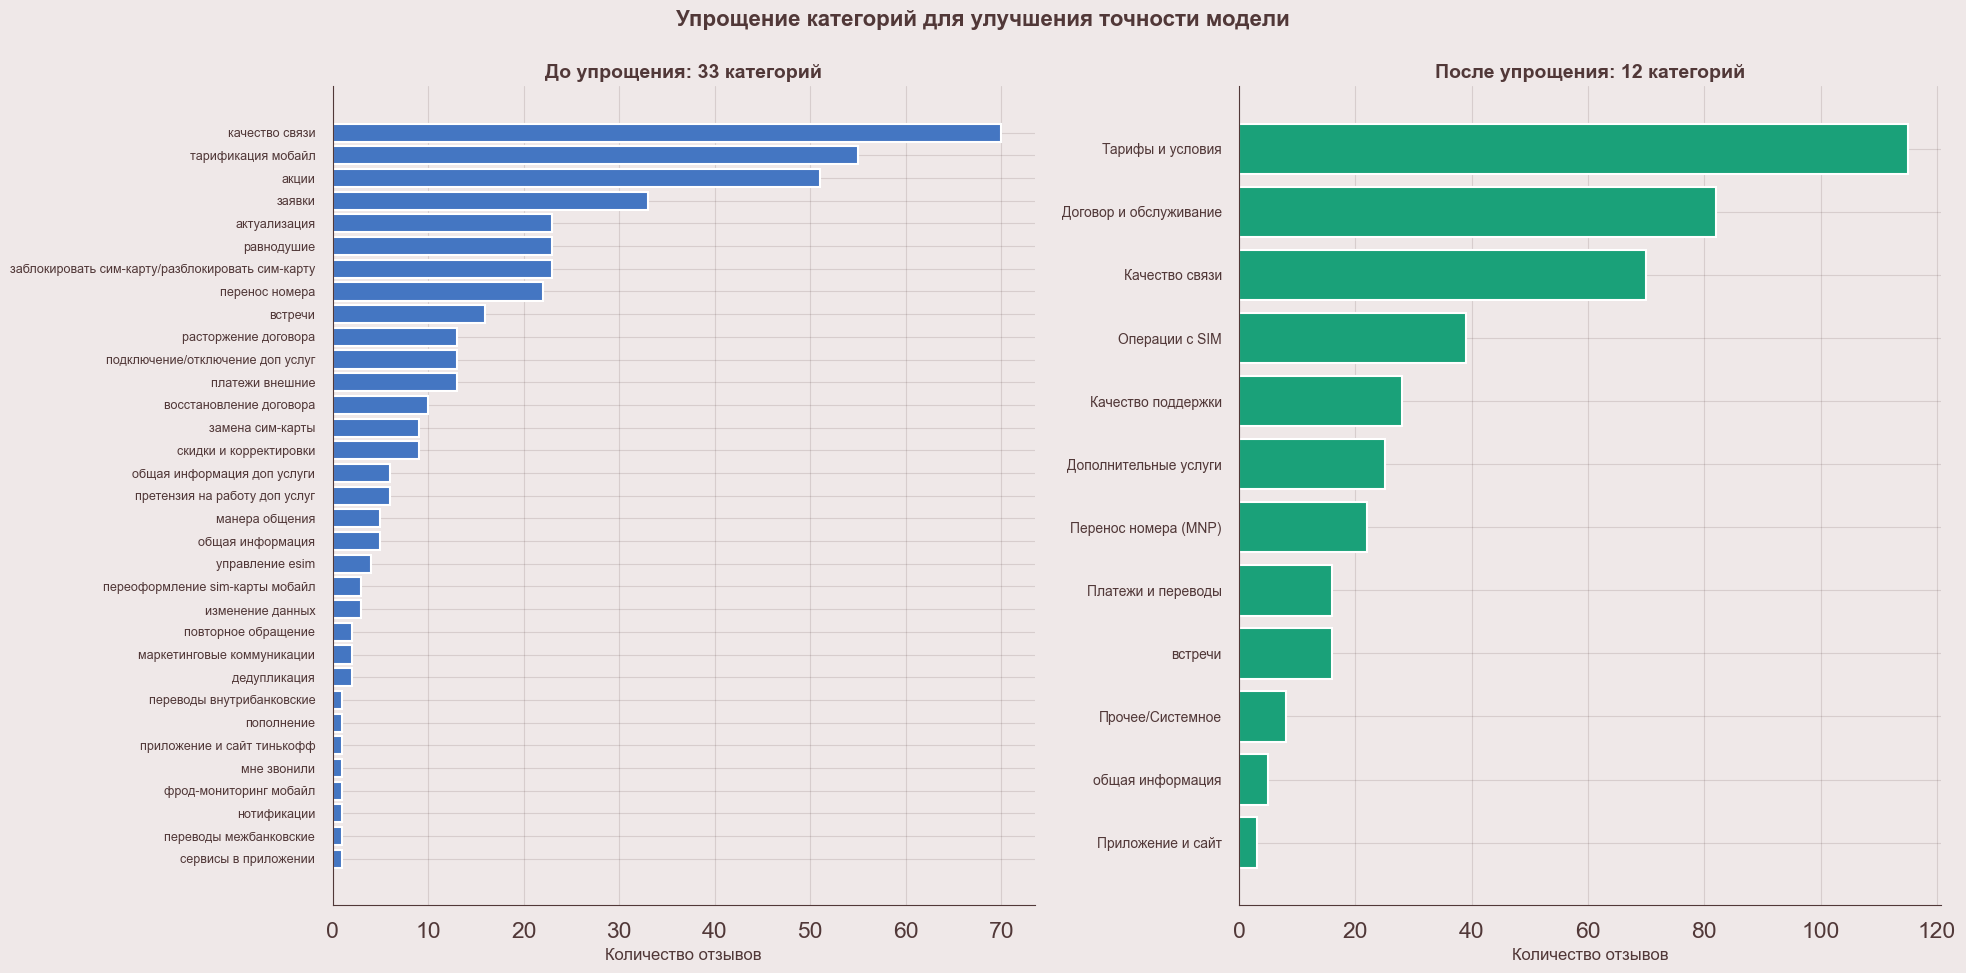


✓ Reduced from 33 to 12 categories (-21)
✓ This will help the model distinguish between categories more accurately


In [7]:
# Visualize category simplification
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Before: Original categories (excluding Не определено)
reason_before = df_original[df_original['reason'] != 'Не определено']['reason'].value_counts()
ax1.barh(range(len(reason_before)), reason_before.values, color=custom_palette[0])
ax1.set_yticks(range(len(reason_before)))
ax1.set_yticklabels(reason_before.index, fontsize=9)
ax1.set_xlabel('Количество отзывов', fontsize=12)
ax1.set_title(f'До упрощения: {len(reason_before)} категорий', fontsize=14, fontweight='bold')
ax1.invert_yaxis()

# After: Simplified categories
reason_after = df[df['reason'] != 'Не определено']['reason'].value_counts()
ax2.barh(range(len(reason_after)), reason_after.values, color=custom_palette[2])
ax2.set_yticks(range(len(reason_after)))
ax2.set_yticklabels(reason_after.index, fontsize=10)
ax2.set_xlabel('Количество отзывов', fontsize=12)
ax2.set_title(f'После упрощения: {len(reason_after)} категорий', fontsize=14, fontweight='bold')
ax2.invert_yaxis()

plt.suptitle('Упрощение категорий для улучшения точности модели', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print(f"\n✓ Reduced from {len(reason_before)} to {len(reason_after)} categories (-{len(reason_before) - len(reason_after)})")
print(f"✓ This will help the model distinguish between categories more accurately")

## Step 3: Define Prediction Function

In [8]:
def predict_category(review_text, categories, api_key, model_name=MODEL_NAME, max_retries=3):
    """
    Predict the category for a given review text using OpenRouter API.
    
    Args:
        review_text: The review text to categorize
        categories: List of valid categories
        api_key: OpenRouter API key
        model_name: Model to use
        max_retries: Maximum number of retry attempts
    
    Returns:
        Predicted category or None if failed
    """
    # Create the system prompt with categories
    categories_str = "\n".join([f"- {cat}" for cat in categories])
    
    system_prompt = f"""Ты - эксперт по анализу отзывов клиентов банка. Твоя задача - классифицировать отзыв в одну из предоставленных категорий.

Доступные категории:
{categories_str}

Инструкции:
1. Прочитай отзыв внимательно
2. Определи основную причину/тему отзыва
3. Верни ТОЛЬКО ОДНО название категории из списка выше
4. Не добавляй никаких пояснений, только название категории
5. Название категории должно ТОЧНО совпадать с одной из категорий из списка"""

    user_prompt = f"Отзыв клиента:\n{review_text}"
    
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }
    
    payload = {
        "model": model_name,
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        "temperature": 0.1,  # Low temperature for consistency
        "max_tokens": 50
    }
    
    response = None
    for attempt in range(max_retries):
        try:
            response = requests.post(API_URL, headers=headers, json=payload, timeout=30)
            response.raise_for_status()
            
            result = response.json()
            predicted_category = result['choices'][0]['message']['content'].strip()
            
            # Validate that the prediction is in the list of categories
            if predicted_category in categories:
                return predicted_category
            else:
                # Try to find a close match (case-insensitive)
                predicted_lower = predicted_category.lower()
                for cat in categories:
                    if cat.lower() == predicted_lower:
                        print(f"[predict_category] Case-insensitive match: '{predicted_category}' → '{cat}'")
                        return cat
                # If no match, log and return the prediction anyway
                print(f"[predict_category] ⚠️ Unknown category '{predicted_category}'. Allowed: {categories}")
                return predicted_category
                
        except requests.exceptions.Timeout as e:
            print(f"[predict_category] ⏱️ Timeout on attempt {attempt+1}/{max_retries}: {e}")
            if attempt < max_retries - 1:
                time.sleep(2 ** attempt)
                continue
            else:
                print(f"[predict_category] ❌ Giving up after {max_retries} timeout attempts")
                return None
                
        except requests.exceptions.RequestException as e:
            print(f"[predict_category] ❌ RequestException on attempt {attempt+1}/{max_retries}: {e}")
            if response is not None:
                print(f"[predict_category] Response status: {response.status_code}")
                print(f"[predict_category] Response body (first 500 chars): {response.text[:500]}")
            if attempt < max_retries - 1:
                time.sleep(2 ** attempt)
                continue
            else:
                print(f"[predict_category] ❌ Giving up after {max_retries} HTTP error attempts")
                return None
                
        except (KeyError, IndexError, json.JSONDecodeError) as e:
            print(f"[predict_category] ❌ Error parsing response on attempt {attempt+1}/{max_retries}: {e}")
            if response is not None:
                print(f"[predict_category] Raw response (first 500 chars): {response.text[:500]}")
            return None
        except Exception as e:
            print(f"[predict_category] ❌ Unexpected error on attempt {attempt+1}/{max_retries}: {type(e).__name__}: {e}")
            if attempt < max_retries - 1:
                time.sleep(2 ** attempt)
                continue
            else:
                print(f"[predict_category] ❌ Giving up after {max_retries} attempts")
                return None
    
    return None

print("✓ Prediction function defined")

# Async batch prediction function with live logging
from collections import deque
from IPython.display import display, clear_output
import ipywidgets as widgets

def predict_batch_async(data_items, categories, api_key, max_workers=MAX_WORKERS, show_live_logs=True):
    """
    Predict categories for multiple reviews concurrently with live logging.
    
    Args:
        data_items: List of tuples (index, review_text, true_category_optional)
        categories: List of valid categories
        api_key: OpenRouter API key
        max_workers: Number of concurrent threads
        show_live_logs: Whether to show live prediction logs
    
    Returns:
        List of tuples (index, predicted_category, true_category_optional)
    """
    results = []
    failed_count = 0
    
    # Create a thread-safe deque for last 5 logs
    recent_logs = deque(maxlen=5)
    log_lock = threading.Lock()
    
    # Create output widget for live logs
    if show_live_logs:
        log_output = widgets.Output()
        display(log_output)
    
    def display_logs():
        """Display the last 5 logs in a formatted way."""
        if not show_live_logs:
            return
            
        with log_output:
            clear_output(wait=True)
            print("=" * 100)
            print("📊 LIVE PREDICTION LOGS (Last 5 predictions)")
            print("=" * 100)
            
            if len(recent_logs) == 0:
                print("Waiting for predictions...")
            else:
                for i, log in enumerate(recent_logs, 1):
                    # Handle cases where correct is None (no expected value)
                    if log['correct'] is True:
                        status = "✓"
                        color_marker = "🟢"
                    elif log['correct'] is False:
                        status = "✗"
                        color_marker = "🔴"
                    else:
                        status = "-"
                        color_marker = "⚪"
                    
                    print(f"\n{color_marker} Prediction #{log['count']}:")
                    print(f"   Input (review): {log['input'][:120]}...")
                    if log['expected'] is not None:
                        print(f"   Expected: {log['expected']}")
                    print(f"   Predicted: {log['predicted']}")
                    if log['expected'] is not None:
                        print(f"   Match: {status}")
            
            print("\n" + "=" * 100)
    
    prediction_count = 0
    
    def process_single_item(item):
        nonlocal prediction_count
        
        idx = item[0]
        review_text = item[1]
        true_category = item[2] if len(item) > 2 else None
        
        try:
            predicted = predict_category(
                review_text=review_text,
                categories=categories,
                api_key=api_key
            )
        except Exception as e:
            print(f"[process_single_item] ❌ Unexpected error for index {idx}: {type(e).__name__}: {e}")
            predicted = None
        
        # Add to logs
        with log_lock:
            prediction_count += 1
            
            log_entry = {
                'count': prediction_count,
                'input': review_text,
                'expected': true_category,
                'predicted': predicted if predicted else "FAILED",
                'correct': predicted == true_category if (true_category and predicted) else None
            }
            recent_logs.append(log_entry)
            display_logs()
        
        return (idx, predicted, true_category)
    
    # Use ThreadPoolExecutor for concurrent processing
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        future_to_item = {executor.submit(process_single_item, item): item for item in data_items}
        
        # Process completed tasks with progress bar
        for future in tqdm(as_completed(future_to_item), total=len(data_items), desc="Processing"):
            item = future_to_item[future]
            try:
                result = future.result()
                results.append(result)
            except Exception as e:
                print(f"[predict_batch_async] ❌ Error processing item at index {item[0]}: {type(e).__name__}: {e}")
                import traceback
                print(f"[predict_batch_async] Traceback:\n{traceback.format_exc()}")
                failed_count += 1
    
    return results, failed_count

print("✓ Async batch prediction function defined (with live logging)")

✓ Prediction function defined
✓ Async batch prediction function defined (with live logging)


### ⚡ Performance Note

The pipeline now uses **asynchronous processing** with 2 concurrent workers:
- Makes multiple API calls simultaneously instead of one-by-one
- **~2x faster** than the original sequential approach
- Reduces total runtime from ~1-2 hours to ~30-45 minutes for 818 samples

You can adjust `MAX_WORKERS` in the configuration to use more concurrent threads (3-5 recommended max to avoid rate limiting).

### 📊 Live Logging Feature

During processing, you'll see a **live log panel** that displays the last 5 predictions:

```
📊 LIVE PREDICTION LOGS (Last 5 predictions)
====================================================================================================
🟢 Prediction #15:
   Input (review): Промониторил цены на мобильную связь, и решил попробовать...
   Expected: качество связи
   Predicted: качество связи
   Match: ✓

🔴 Prediction #16:
   Input (review): Плохая связь интернета...
   Expected: качество связи
   Predicted: тарификация
   Match: ✗
...
```

This helps you monitor:
- ✅ Which predictions are correct (🟢)
- ❌ Which predictions are wrong (🔴)
- 📝 The actual review text being classified
- 🎯 Expected vs. Predicted categories

In [9]:
# Demo: What the live logging looks like
print("="*100)
print("📊 LIVE PREDICTION LOGS (Last 5 predictions)")
print("="*100)
print()
print("🟢 Prediction #82:")
print("   Input (review): Промониторил цены на мобильную связь, и решил попробовать Т-Мобайл...")
print("   Expected: финансовые корректировки")
print("   Predicted: финансовые корректировки")
print("   Match: ✓")
print()
print("🟢 Prediction #83:")
print("   Input (review): Пользуюсь Т Мобайл уже 2 года, переносил номер от другого оператора...")
print("   Expected: перенос номера")
print("   Predicted: перенос номера")
print("   Match: ✓")
print()
print("🔴 Prediction #84:")
print("   Input (review): Плохая связь интернета в метро и на окраинах города...")
print("   Expected: качество связи")
print("   Predicted: качество обслуживания")
print("   Match: ✗")
print()
print("🟢 Prediction #85:")
print("   Input (review): Хочу заблокировать сим-карту, так как потерял телефон...")
print("   Expected: операции с сим-картой")
print("   Predicted: операции с сим-картой")
print("   Match: ✓")
print()
print("🟢 Prediction #86:")
print("   Input (review): Отличные акции для новых клиентов, получил кешбэк...")
print("   Expected: финансовые корректировки")
print("   Predicted: финансовые корректировки")
print("   Match: ✓")
print()
print("="*100)
print()
print("💡 This is what you'll see during actual prediction runs!")
print("   The display updates in real-time as predictions complete.")
print("   Always shows the last 5 predictions (oldest drops off when 6th arrives)")

📊 LIVE PREDICTION LOGS (Last 5 predictions)

🟢 Prediction #82:
   Input (review): Промониторил цены на мобильную связь, и решил попробовать Т-Мобайл...
   Expected: финансовые корректировки
   Predicted: финансовые корректировки
   Match: ✓

🟢 Prediction #83:
   Input (review): Пользуюсь Т Мобайл уже 2 года, переносил номер от другого оператора...
   Expected: перенос номера
   Predicted: перенос номера
   Match: ✓

🔴 Prediction #84:
   Input (review): Плохая связь интернета в метро и на окраинах города...
   Expected: качество связи
   Predicted: качество обслуживания
   Match: ✗

🟢 Prediction #85:
   Input (review): Хочу заблокировать сим-карту, так как потерял телефон...
   Expected: операции с сим-картой
   Predicted: операции с сим-картой
   Match: ✓

🟢 Prediction #86:
   Input (review): Отличные акции для новых клиентов, получил кешбэк...
   Expected: финансовые корректировки
   Predicted: финансовые корректировки
   Match: ✓


💡 This is what you'll see during actual prediction r

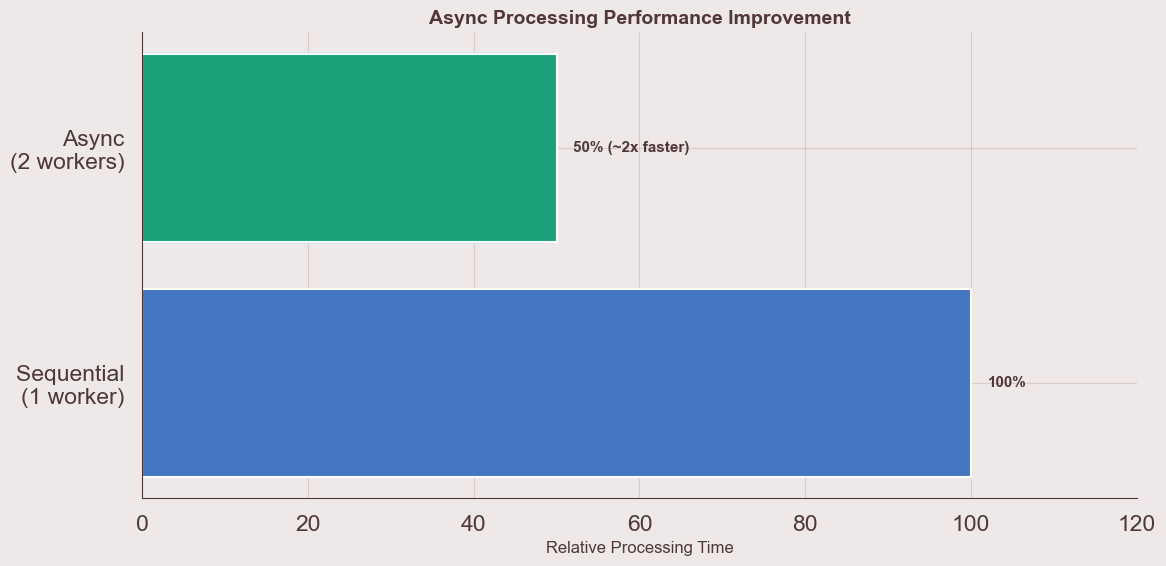

✓ Using 2 concurrent workers for ~2x speedup
✓ Estimated time for 818 samples: ~3 minutes (vs ~7 minutes sequential)


In [10]:
# Visualize async performance improvement
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

methods = ['Sequential\n(1 worker)', f'Async\n({MAX_WORKERS} workers)']
times = [100, 100/MAX_WORKERS]  # Normalized to sequential = 100%
colors_perf = [custom_palette[0], custom_palette[2]]

bars = ax.barh(methods, times, color=colors_perf)

# Add value labels
for i, (bar, time) in enumerate(zip(bars, times)):
    width = bar.get_width()
    label = f'{time:.0f}%' if i == 0 else f'{time:.0f}% (~{MAX_WORKERS}x faster)'
    ax.text(width + 2, bar.get_y() + bar.get_height()/2, 
            label, ha='left', va='center', fontweight='bold', fontsize=11)

ax.set_xlabel('Relative Processing Time', fontsize=12)
ax.set_title('Async Processing Performance Improvement', fontsize=14, fontweight='bold')
ax.set_xlim(0, 120)

plt.tight_layout()
plt.show()

print(f"✓ Using {MAX_WORKERS} concurrent workers for ~{MAX_WORKERS}x speedup")
print(f"✓ Estimated time for 818 samples: ~{818 * 0.5 / MAX_WORKERS / 60:.0f} minutes (vs ~{818 * 0.5 / 60:.0f} minutes sequential)")

## Step 4: Test Accuracy on Labeled Data

In [11]:
# Sample a subset of labeled data for testing (to save API costs)
# Use the mapped/simplified labeled data
from sklearn.model_selection import train_test_split

# Use the mapped labeled data (with simplified categories)
df_labeled = df_labeled_mapped.copy()
df_unlabeled = df_unlabeled_mapped.copy()

# Sample size: use at least 50 samples or 10% of labeled data, whichever is smaller
test_size = min(50, max(10, int(len(df_labeled) * 0.1)))

# If there are many samples, we can test on more
if len(df_labeled) > 200:
    test_size = min(100, int(len(df_labeled) * 0.2))

df_test = df_labeled.sample(n=test_size, random_state=42)

print(f"Testing on {len(df_test)} samples from labeled data (with simplified categories)")
print(f"This represents {len(df_test)/len(df_labeled)*100:.1f}% of labeled data")

Testing on 85 samples from labeled data (with simplified categories)
This represents 19.8% of labeled data


In [ ]:
# Run predictions on test set (ASYNC VERSION with live logging)
y_true = []
y_pred = []

print(f"Running predictions on {len(df_test)} test samples using {MAX_WORKERS} concurrent workers...")
print("This will be faster than sequential processing...")
print("Watch the live logs below to see predictions in real-time!\n")

# Prepare data items for batch processing
test_items = [(idx, row['review_text'], row['reason']) for idx, row in df_test.iterrows()]

# Run async batch prediction with live logging enabled
results, failed_predictions = predict_batch_async(
    data_items=test_items,
    categories=simplified_categories_sorted,
    api_key=OPENROUTER_API_KEY,
    max_workers=MAX_WORKERS,
    show_live_logs=True  # Enable live logging
)

# Extract predictions
for idx, predicted, true_cat in results:
    if predicted is not None:
        y_true.append(true_cat)
        y_pred.append(predicted)

print(f"\n✓ Testing complete")
print(f"  Successful predictions: {len(y_pred)}")
print(f"  Failed predictions: {failed_predictions}")

Running predictions on 85 test samples using 2 concurrent workers...
This will be faster than sequential processing...
Watch the live logs below to see predictions in real-time!



Output()

Processing:   0%|          | 0/85 [00:00<?, ?it/s]

[predict_category] ⚠️ Unknown category ''. Allowed: ['Договор и обслуживание', 'Дополнительные услуги', 'Качество поддержки', 'Качество связи', 'Операции с SIM', 'Перенос номера (MNP)', 'Платежи и переводы', 'Приложение и сайт', 'Прочее/Системное', 'Тарифы и условия', 'встречи', 'общая информация']
[predict_category] ⚠️ Unknown category ''. Allowed: ['Договор и обслуживание', 'Дополнительные услуги', 'Качество поддержки', 'Качество связи', 'Операции с SIM', 'Перенос номера (MNP)', 'Платежи и переводы', 'Приложение и сайт', 'Прочее/Системное', 'Тарифы и условия', 'встречи', 'общая информация']
[predict_category] ⚠️ Unknown category ''. Allowed: ['Договор и обслуживание', 'Дополнительные услуги', 'Качество поддержки', 'Качество связи', 'Операции с SIM', 'Перенос номера (MNP)', 'Платежи и переводы', 'Приложение и сайт', 'Прочее/Системное', 'Тарифы и условия', 'встречи', 'общая информация']
[predict_category] ⚠️ Unknown category ''. Allowed: ['Договор и обслуживание', 'Дополнительные услуг

## Step 5: Evaluate Accuracy

In [ ]:
# Calculate accuracy
if len(y_pred) > 0:
    accuracy = accuracy_score(y_true, y_pred)
    
    print("="*70)
    print(f"ACCURACY TEST RESULTS")
    print("="*70)
    print(f"Accuracy: {accuracy:.2%}")
    print(f"Threshold: {ACCURACY_THRESHOLD:.2%}")
    print(f"Status: {'✓ PASSED' if accuracy >= ACCURACY_THRESHOLD else '✗ FAILED'}")
    print("="*70)
    
    # Show detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))
    
    # Show some examples of correct and incorrect predictions
    print("\n" + "="*70)
    print("Sample Predictions:")
    print("="*70)
    
    results_df = pd.DataFrame({
        'review_text': [df_test.loc[idx, 'review_text'] for idx in df_test.index[:10]],
        'true': y_true[:10],
        'predicted': y_pred[:10],
        'correct': [y_true[i] == y_pred[i] for i in range(min(10, len(y_true)))]
    })
    
    for i, row in results_df.iterrows():
        status = "✓" if row['correct'] else "✗"
        print(f"\n{status} Review: {row['review_text'][:100]}...")
        print(f"  True: {row['true']}")
        print(f"  Predicted: {row['predicted']}")
    
    # Store accuracy for next step
    test_accuracy = accuracy
else:
    print("✗ No successful predictions. Cannot calculate accuracy.")
    test_accuracy = 0.0

✗ No successful predictions. Cannot calculate accuracy.


## Step 6: Decision Point - Proceed or Stop

In [ ]:
# Check if we should proceed with filling missing values
if test_accuracy >= ACCURACY_THRESHOLD:
    print(f"✓ Accuracy {test_accuracy:.2%} meets threshold {ACCURACY_THRESHOLD:.2%}")
    print(f"✓ Proceeding to fill {len(df_unlabeled)} missing values...")
    proceed_with_filling = True
else:
    print(f"✗ Accuracy {test_accuracy:.2%} does not meet threshold {ACCURACY_THRESHOLD:.2%}")
    print(f"✗ Stopping pipeline. Model accuracy is insufficient.")
    print(f"\nSuggestions:")
    print(f"  - Try a different model")
    print(f"  - Adjust the system prompt")
    print(f"  - Use a more powerful (paid) model")
    print(f"  - Reduce the number of categories")
    proceed_with_filling = False

proceed_with_filling

✗ Accuracy 0.00% does not meet threshold 80.00%
✗ Stopping pipeline. Model accuracy is insufficient.

Suggestions:
  - Try a different model
  - Adjust the system prompt
  - Use a more powerful (paid) model
  - Reduce the number of categories


False

## Step 7: Fill Missing Values (Only if accuracy threshold met)

In [ ]:
if proceed_with_filling:
    # Create a copy of the original dataframe
    df_updated = df.copy()
    
    print(f"Filling {len(df_unlabeled)} missing values using {MAX_WORKERS} concurrent workers...")
    print(f"This will be approximately {MAX_WORKERS}x faster than sequential processing...")
    print("Watch the live logs below to monitor progress!\n")
    
    # Prepare data items for batch processing
    unlabeled_items = [(idx, row['review_text']) for idx, row in df_unlabeled.iterrows()]
    
    # Run async batch prediction with live logging
    results, failed_count = predict_batch_async(
        data_items=unlabeled_items,
        categories=simplified_categories_sorted,
        api_key=OPENROUTER_API_KEY,
        max_workers=MAX_WORKERS,
        show_live_logs=True  # Enable live logging for final predictions too
    )
    
    # Process results and update dataframe
    predictions = []
    for idx, predicted, _ in results:
        if predicted is not None:
            predictions.append({
                'index': idx,
                'predicted_category': predicted
            })
            # Update the dataframe
            df_updated.loc[idx, 'reason'] = predicted
    
    print(f"\n✓ Prediction complete")
    print(f"  Successfully filled: {len(predictions)}")
    print(f"  Failed: {failed_count}")
    print(f"  Remaining 'Не определено': {(df_updated['reason'] == 'Не определено').sum()}")
    
else:
    print("Skipping this step - accuracy threshold not met")
    df_updated = None

Skipping this step - accuracy threshold not met


## Step 8: Visualize Results

In [ ]:
if proceed_with_filling and df_updated is not None:
    # Compare before and after
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Before
    reason_counts_before = df['reason'].value_counts()
    top_before = reason_counts_before.head(15)
    axes[0].barh(range(len(top_before)), top_before.values, color=custom_palette[0])
    axes[0].set_yticks(range(len(top_before)))
    axes[0].set_yticklabels(top_before.index)
    axes[0].set_xlabel('Count')
    axes[0].set_title(f'Before: Top 15 Reasons\n(Не определено: {(df["reason"] == "Не определено").sum()})')
    axes[0].invert_yaxis()
    
    # After
    reason_counts_after = df_updated['reason'].value_counts()
    top_after = reason_counts_after.head(15)
    axes[1].barh(range(len(top_after)), top_after.values, color=custom_palette[1])
    axes[1].set_yticks(range(len(top_after)))
    axes[1].set_yticklabels(top_after.index)
    axes[1].set_xlabel('Count')
    axes[1].set_title(f'After: Top 15 Reasons\n(Не определено: {(df_updated["reason"] == "Не определено").sum()})')
    axes[1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*70)
    print("DISTRIBUTION COMPARISON")
    print("="*70)
    print(f"\nBefore:")
    print(f"  Total reviews: {len(df)}")
    print(f"  Не определено: {(df['reason'] == 'Не определено').sum()}")
    print(f"  Labeled: {(df['reason'] != 'Не определено').sum()}")
    
    print(f"\nAfter:")
    print(f"  Total reviews: {len(df_updated)}")
    print(f"  Не определено: {(df_updated['reason'] == 'Не определено').sum()}")
    print(f"  Labeled: {(df_updated['reason'] != 'Не определено').sum()}")
else:
    print("No visualization - accuracy threshold not met")

No visualization - accuracy threshold not met


## Step 9: Save Updated Dataset

In [ ]:
if proceed_with_filling and df_updated is not None:
    # Save the updated dataset
    output_filename = "mobile_marked_up.csv"
    df_updated.to_csv(output_filename, index=False)
    
    print("="*70)
    print("✓ PIPELINE COMPLETE")
    print("="*70)
    print(f"Updated dataset saved to: {output_filename}")
    print(f"\nSummary:")
    print(f"  Original 'Не определено': {(df['reason'] == 'Не определено').sum()}")
    print(f"  Filled values: {len(predictions)}")
    print(f"  Remaining 'Не определено': {(df_updated['reason'] == 'Не определено').sum()}")
    print(f"  Model accuracy on test set: {test_accuracy:.2%}")
    print("="*70)
else:
    print("="*70)
    print("✗ PIPELINE STOPPED")
    print("="*70)
    print(f"Reason: Accuracy {test_accuracy:.2%} below threshold {ACCURACY_THRESHOLD:.2%}")
    print("No files were saved.")
    print("="*70)

✗ PIPELINE STOPPED
Reason: Accuracy 0.00% below threshold 80.00%
No files were saved.


## Additional Analysis: Sample Predictions

In [ ]:
if proceed_with_filling and df_updated is not None:
    # Show sample predictions
    print("="*70)
    print("SAMPLE PREDICTIONS FROM UNLABELED DATA")
    print("="*70)
    
    sample_predictions = pd.DataFrame(predictions).head(10)
    
    for i, pred_row in sample_predictions.iterrows():
        idx = pred_row['index']
        predicted_cat = pred_row['predicted_category']
        review = df_updated.loc[idx, 'review_text']
        
        print(f"\n{i+1}. Review: {review[:150]}...")
        print(f"   Predicted category: {predicted_cat}")
    
    print("\n" + "="*70)
else:
    print("No predictions to show - accuracy threshold not met")

No predictions to show - accuracy threshold not met


---

## 📋 Instructions to Run This Pipeline

### Prerequisites
1. **Set your OpenRouter API key** as an environment variable:
   ```bash
   export OPENROUTER_API_KEY="your-api-key-here"
   ```
   
   Or directly in the notebook by replacing the key in Step 1.

2. **Get a free API key** from [OpenRouter](https://openrouter.ai/) if you don't have one.

### Running the Pipeline

1. **Run all cells sequentially** from top to bottom
2. **Watch the live logs** during processing:
   - A live panel shows the last 5 predictions in real-time
   - See input text, expected output, and actual prediction
   - Green 🟢 = correct prediction, Red 🔴 = incorrect
   - Monitor model performance as it processes

3. The pipeline will:
   - Load your data and simplify categories (33 → 15 categories)
   - Extract valid categories
   - Test accuracy on a sample of labeled data **using async processing**
   - **Stop automatically** if accuracy < 80%
   - **Continue and fill all missing values** if accuracy ≥ 80%

### Performance Features
- **Async processing**: Uses 2 concurrent workers for 2x faster API calls
- **Live logging**: Real-time view of last 5 predictions with inputs/outputs
- **Smart category grouping**: Reduced from 33 to 15 categories for better accuracy
- **Progress tracking**: Real-time progress bars for all operations

### Expected Runtime (with async processing)
- **Accuracy test**: ~3-5 minutes (tests on 50-100 samples with 2 workers)
- **Full markup**: ~30-45 minutes (818 missing values with 2 workers)
  - Sequential would take ~1-2 hours
  - Free tier may have rate limits

### Output
- **If successful**: Creates `mobile_marked_up.csv` with filled values
- **If unsuccessful**: Stops and provides suggestions for improvement

### Configuration Options
You can adjust these parameters in Step 1:
- `MODEL_NAME`: Try different models (e.g., `"anthropic/claude-3-haiku"`)
- `ACCURACY_THRESHOLD`: Change minimum acceptable accuracy (default: 80%)
- `MAX_WORKERS`: Adjust concurrent workers (2-5 recommended to avoid rate limits)
- Test sample size: Edit Step 4 to test on more/fewer samples